In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2
from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Check GPU
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# import package
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D, GlobalAveragePooling2D)
from keras.callbacks import TensorBoard
from keras.applications import MobileNet, MobileNetV2, VGG16, VGG19, Xception
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
   
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

#xception model
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


Using TensorFlow backend.


In [4]:
# read the file image into a list

data_path = "./training_set"

x_data_list_originial = []
y_data_list_originial = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list_originial.append(os.path.join(roots, each))
            y_data_list_originial.append(roots.split("/")[-1])

In [5]:
# decide on the image size 
img_size = 224

In [ ]:
# ##check out images with read & resize code

# img_read = cv2.imread(x_data_list_originial[79])[...,::-1] ## read picture with RGB
# img_read_resized = cv2.resize(img_read, (img_size, img_size))
# print(img_read_resized.shape)

# ############ use classifier to create bonding box
# classifier = CascadeClassifier('./haarcascade_frontalface_default.xml')
# # perform face detection
# bboxes = classifier.detectMultiScale(img_read_resized,scaleFactor=1.05)
# # print bounding box for each detected face
# for box in bboxes:
# 	# extract
# 	x, y, width, height = box
# 	x2, y2 = x + width, y + height
# 	# draw a rectangle over the pixels
# 	rectangle(img_read_resized, (x, y), (x2, y2), (0,0,255), 1)
# # show the image
# plt.imshow(img_read_resized)
# plt.axis('off')
# plt.show()
# #print(box)  # show upper left corner x,y coords, then xlength, ylength
# #imshow('face detection',img_read_resized)
# #imshow('face detection', img_read_resized)
# x2

In [ ]:
# newimg=img_read_resized[y:y2,x:x2,:]# : in last index all colours
# plt.imshow(newimg)
# newimg.shape

In [ ]:
#### read & resize image (incase the images are different sizes)
## function for process all images 
## create bonding box for images also

# def load_img(data_list):
#     data_img = []
#     for each in tqdm(data_list):
#         img = cv2.imread(each)[...,::-1] 
#         img = cv2.resize(img, (img_size, img_size))
        
#         ########
#         #print(img.shape)
#         # perform face detection
#         bboxes = classifier.detectMultiScale(img)
#         # print bounding box for each detected face
#         maxwidth = 1
#         maxheight = 1
#         bestx = 0
#         besty = 0
#         for box in bboxes:
#             # extract
#             x, y, width, height = box
#             if (width*height) > (maxwidth*maxheight):
#                 bestx, besty, maxwidth, maxheight = box
#         if maxwidth>1:
#             #print(box)
            
#             img = cv2.resize(img[besty:besty+maxheight,bestx:bestx+maxwidth,:],(img_size,img_size))
#         #print(bestx)
#         data_img.append(img[...]) ##no need to add extra greyscale layer 

#     return np.array(data_img).astype('float32')
#RGB has value of 255 (take off "/255" for vgg  model since vgg has pre-process)

In [6]:
##import x_data from different file
x_data = np.load('./x_data.npy')
#print(x_data)

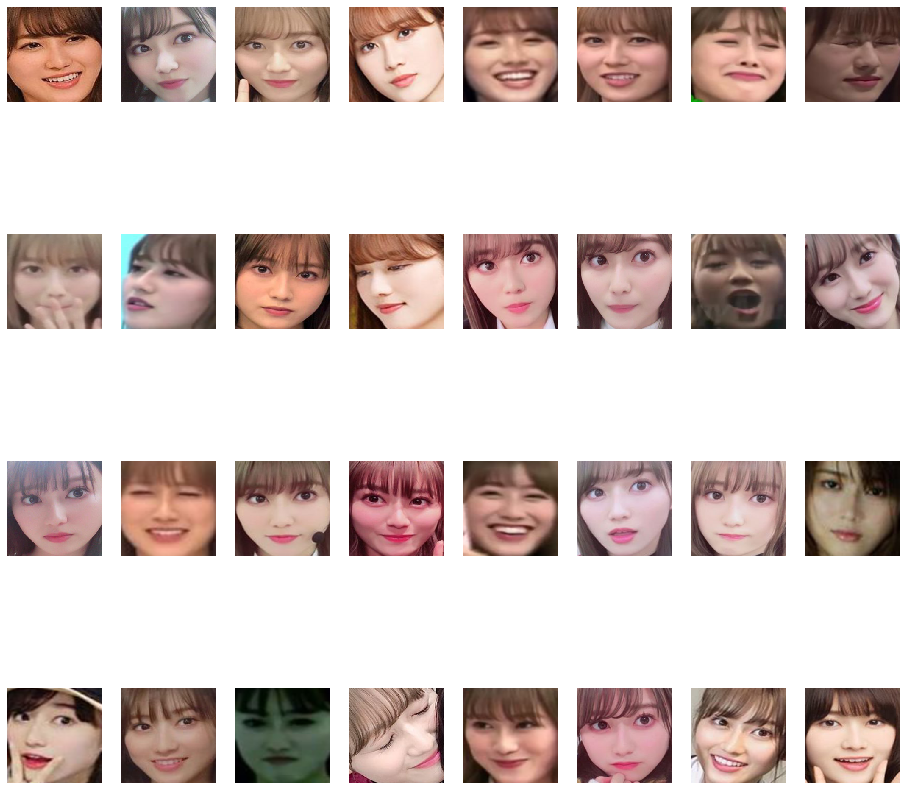

In [7]:
# show post-processed image
plt.figure(figsize=(16, 16))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(x_data[i+0]/255.0)
    plt.axis('off')
plt.show()
#print(y_data_list_originial)
#print(x_data_list_originial)

In [9]:
#get the labelled information into dataframe

y_data_list = pd.DataFrame(y_data_list_originial, columns=['label'])
uniques_label = y_data_list['label'].value_counts().index
counts_label = y_data_list['label'].value_counts().values

In [ ]:
#plot category information in bar graph for distribution

# plt.figure(figsize=(30, 5))
# plt.bar(uniques_label, counts_label)
# plt.xticks(fontsize=16)
# plt.show()

In [10]:
#match the label information(mapping.txt) to the labels

class_path = "./"
class_map_read = pd.read_csv(os.path.join(class_path, 'classmap.csv'),
                        header=None, index_col=0)
class_map = class_map_read.to_dict()[1]

In [11]:
y_data = y_data_list['label'].map(class_map).values.copy()

x_data.shape

(538, 224, 224, 3)

In [13]:
#VGG preprocess beacuse vgg uses bgr instead of RBG
tf.keras.applications.vgg16.preprocess_input(x_data)

# print(x_data)


array([[[[ -73.939     ,  -72.779     ,  -50.68      ],
         [ -67.939     ,  -67.779     ,  -43.68      ],
         [ -59.939003  ,  -59.779     ,  -34.68      ],
         ...,
         [ -80.939     ,  -95.779     ,  -83.68      ],
         [ -61.939003  ,  -76.779     ,  -66.68      ],
         [ -47.939003  ,  -63.779     ,  -54.68      ]],

        [[ -71.939     ,  -68.779     ,  -46.68      ],
         [ -65.939     ,  -63.779     ,  -40.68      ],
         [ -56.939003  ,  -55.779     ,  -30.68      ],
         ...,
         [ -80.939     ,  -94.779     ,  -83.68      ],
         [ -65.939     ,  -80.779     ,  -70.68      ],
         [ -53.939003  ,  -69.779     ,  -60.68      ]],

        [[ -70.939     ,  -67.779     ,  -45.68      ],
         [ -67.939     ,  -64.779     ,  -41.68      ],
         [ -63.939003  ,  -61.779     ,  -36.68      ],
         ...,
         [ -74.939     ,  -87.779     ,  -76.68      ],
         [ -69.939     ,  -84.779     ,  -74.68      ],
  

In [14]:
##split train & validaton set

from sklearn.model_selection import train_test_split
x_train, x_test, y_train_split, y_test_split = train_test_split(x_data, y_data,
                                                    test_size=0.3,
                                                    random_state=10,
                                                    stratify=y_data)

In [15]:
#plot category information in bar graph for distribution in train dataset


uniques, counts = np.unique(y_test_split, return_counts=True)

# plt.figure(figsize=(30, 5))
# plt.bar(uniques, counts)
# plt.xticks(fontsize=16)
# plt.show()

In [16]:
## y_train contain strings, needs to be converted

y_train_in = [int(y_train_split[i]) for i in range(0, len(y_train_split))]
y_test_in = [int(y_test_split[i]) for i in range(0, len(y_test_split))]

# ##one hot encodes all the categories

num_classes = len(uniques)

y_train = np.eye(num_classes, dtype='float32')[y_train_in]
y_test = np.eye(num_classes, dtype='float32')[y_test_in]
print('y_train shape:', y_train.shape)

y_train shape: (376, 5)


In [17]:
##Model - VGG
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')

In [18]:
##VGG setting 
VGG16_MODEL.trainable=False

for layer in VGG16_MODEL.layers[:-4]:
    layer.trainable=False


In [37]:
#VGG model
model = tf.keras.Sequential([
  VGG16_MODEL,
   tf.keras.layers.Flatten(),
   tf.keras.layers.BatchNormalization(),
   tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='relu'),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 25088)             100352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 125445    
Total params: 14,940,485
Trainable params: 175,621
Non-trainable params: 14,764,864
_________________________________________________________________


In [38]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(lr=learning_rate)
batch_size = 32
epochs = 60

In [39]:
# initiate optimizer
model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [40]:
model_dir = './Model/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=10,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [41]:
num_step = x_train.shape[0] // batch_size
print(x_train.shape)
print(x_test.shape)

(376, 224, 224, 3)
(162, 224, 224, 3)


In [ ]:
###create file of weight to reduce running time (load for the second run)
##self-made model is good for epochs 70

#model.load_weights('./temp_weights/')

In [42]:
datagen = ImageDataGenerator(
                              width_shift_range=0.01,
                              height_shift_range=0.01,
                              brightness_range=[0.2,1.0],
                              horizontal_flip=True,
                              #vertical_flip=False,
                              fill_mode='nearest',
                              cval=0,
                              )


history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                   steps_per_epoch=num_step,
                                   epochs=epochs,
                                   validation_data=(x_test, y_test),
                                   callbacks=callbacks_list
                                  )

Epoch 1/60
11/11 [==============================] - 7s 672ms/step - loss: 1.8540 - accuracy: 0.3895 - val_loss: 3.3026 - val_accuracy: 0.4753
Epoch 2/60
11/11 [==============================] - 7s 651ms/step - loss: 0.8618 - accuracy: 0.7216 - val_loss: 2.8669 - val_accuracy: 0.5679
Epoch 3/60
11/11 [==============================] - 7s 629ms/step - loss: 0.3288 - accuracy: 0.9077 - val_loss: 2.6145 - val_accuracy: 0.5741
Epoch 4/60
11/11 [==============================] - 7s 609ms/step - loss: 0.3090 - accuracy: 0.8892 - val_loss: 2.6988 - val_accuracy: 0.5741
Epoch 5/60
11/11 [==============================] - 7s 604ms/step - loss: 0.2165 - accuracy: 0.9375 - val_loss: 2.7626 - val_accuracy: 0.5988
Epoch 6/60
11/11 [==============================] - 7s 596ms/step - loss: 0.1146 - accuracy: 0.9716 - val_loss: 2.5744 - val_accuracy: 0.5679
Epoch 7/60
11/11 [==============================] - 6s 572ms/step - loss: 0.1653 - accuracy: 0.9593 - val_loss: 2.5273 - val_accuracy: 0.5802
Epoch 

In [43]:
model.save_weights('./temp_weights/')

In [44]:
model = load_model('./Model/model-logs/basic_model-best-model.h5')
loss, acc = model.evaluate(x_test, y_test, verbose=2)

162/1 - 1s - loss: 2.3760 - accuracy: 0.6111


In [45]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(-1)

In [46]:
class_names = np.array([each for each in class_map.keys()])

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test.argmax(-1), y_pred))
print(confusion_matrix(y_test.argmax(-1), y_pred))

0.6111111111111112
[[10  8  1  3  8]
 [ 4 22  1  1  3]
 [ 3  4 19  3  5]
 [ 2  9  1 18  2]
 [ 2  1  2  0 30]]


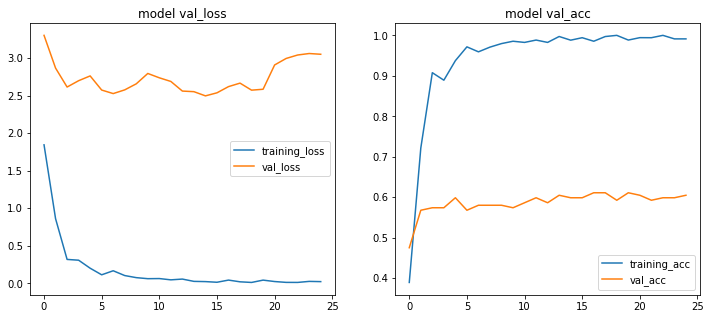

In [48]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)
plt.show()

In [49]:
##clean up data for the testset

data_path = "./testing_set"

test_image = []
test_image_id = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            test_image.append(os.path.join(roots, each))
            #need the full diectory to run load image
            test_image_id.append(each.split(".")[0])

# load data from import data

In [50]:
#use the function to load image(see cell-7 at beginning of the code)

#test_train = load_img(test_image)
test_train = np.load('./test_train.npy')

print(test_train.shape)

(438, 224, 224, 3)


In [52]:
tf.keras.applications.vgg16.preprocess_input(test_train)
#tf.keras.preprocess.image.img_to_array(test_train)


array([[[[-4.6939003e+01, -5.2778999e+01, -4.2680000e+01],
         [-4.2939003e+01, -4.8778999e+01, -3.8680000e+01],
         [-3.3939003e+01, -3.9778999e+01, -2.9680000e+01],
         ...,
         [-5.1939003e+01, -5.5778999e+01, -3.3680000e+01],
         [-6.0939003e+01, -6.3778999e+01, -4.1680000e+01],
         [-6.4939003e+01, -6.6778999e+01, -4.5680000e+01]],

        [[-4.3939003e+01, -4.9778999e+01, -3.9680000e+01],
         [-3.9939003e+01, -4.5778999e+01, -3.5680000e+01],
         [-3.2939003e+01, -3.8778999e+01, -2.8680000e+01],
         ...,
         [-5.0939003e+01, -5.4778999e+01, -3.2680000e+01],
         [-5.7939003e+01, -6.0778999e+01, -3.8680000e+01],
         [-6.0939003e+01, -6.2778999e+01, -4.1680000e+01]],

        [[-3.8939003e+01, -4.4778999e+01, -3.4680000e+01],
         [-3.6939003e+01, -4.2778999e+01, -3.2680000e+01],
         [-3.0939003e+01, -3.7778999e+01, -2.7680000e+01],
         ...,
         [-4.8939003e+01, -5.2778999e+01, -3.1680000e+01],
         [

In [53]:
#prediction for test dataset
ans = model.predict(test_train)
result = np.argmax(ans,axis=1)
result_lst = result.tolist()

In [54]:
print(len(result_lst))
print(len(test_image_id))

438
438


In [55]:
test_submission = pd.DataFrame({'Id':test_image_id, 'class': result_lst})
test_submission.to_csv('./test_submission.csv', index = False)